In [2]:
%load_ext rpy2.ipython

/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
packnames = ('ggplot2', 'dplyr', 'tidyr', 'lme4', 'data.table', 'lmerTest', 'effects', 'pander', 'psych', 'Hmisc', 'ggpubr', 'ggrepel')

# R vector of strings
from rpy2.robjects.vectors import StrVector

utils.install_packages(StrVector(packnames))


/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cloud.r-project.org/src/contrib/ggplot2_3.2.1.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3204655 bytes (3.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 3.1 MB


  warni

rpy2.rinterface.NULL

In [4]:
dplyr = rpackages.importr("dplyr")
tidyr = rpackages.importr("tidyr")
ggplot2 = rpackages.importr("ggplot2")
ggpubr = rpackages.importr("ggpubr")
lme4 = rpackages.importr("lme4")  
# data.table = rpackages.importr("data.table")
lmerTest = rpackages.importr("lmerTest")
effects = rpackages.importr("effects")
pander = rpackages.importr("pander")
psych = rpackages.importr("psych")
Hmisc = rpackages.importr("Hmisc")
ggpubr = rpackages.importr("ggpubr")
ggrepel = rpackages.importr("ggrepel")

In [16]:
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

string = """
is_outlier <- function(x) {
  return(x < quantile(x, 0.25) - 1.5 * IQR(x) | x > quantile(x, 0.75) + 1.5 * IQR(x))
}
"""

is_outlier = SignatureTranslatedAnonymousPackage(string, "is_outlier")

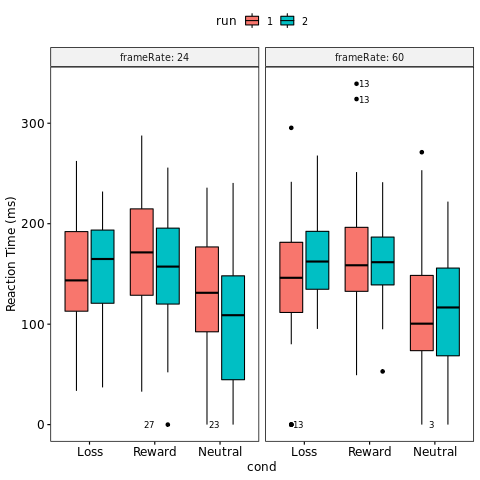

In [12]:
%%R
MID_long <- read.csv("/corral-secure/utdmc/Dell-Medical-Imaging/ULG/BIDS/derivatives/repo/fMRI-tasks/MID/data/MID_merged_bdat.csv")
MID_long$probeResp.corr <- as.integer(MID_long$probeResp.corr)
MID_long$run <- as.factor(MID_long$run)

# replace NA with 0s
MID_long$probeResp.corr[is.na(MID_long$probeResp.corr)] <- 0
MID_long$probeResp.rt[is.na(MID_long$probeResp.rt)] <- 0

MID_wide <- MID_long %>% 
  filter(Condition != "") %>%
  group_by(participant, Condition, run) %>%
  summarise(meanacc = mean(probeResp.corr), meanrt =1000* mean(probeResp.rt, na.rm=TRUE), frameRate = mean(frameRate))

# recategorize conditions
MID_wide <- MID_wide %>% mutate(cond = case_when(
        Condition == "LgPun" | Condition == "SmallPun" ~ "Loss",
        Condition == "LgReward" | Condition == "SmallReward" ~ "Reward", 
        Condition == "Triangle" ~ "Neutral")) 

MID_wide <- MID_wide %>% mutate(frameRate = case_when(
        frameRate < 40 ~  24,
        frameRate > 50 ~ 60))

MID_wide$frameRate <- as.factor(MID_wide$frameRate)

ggdensity(MID_long, x = "frameRate")

ggboxplot(MID_wide, "cond", "meanacc", fill = "run", ylab = "Hit Rate", facet.by = "frameRate", short.panel.labs = FALSE) + 
  geom_text(aes(label=ifelse((meanacc < quantile(meanacc, 0.25) - 1.5 * IQR(meanacc) | meanacc > quantile(meanacc, 0.75) + 1.5 * IQR(meanacc)),paste(participant),"")), hjust=1.1, check_overlap = TRUE, size=3, position = position_dodge(1))

# meanrt is for correct trials only
ggboxplot(MID_wide, "cond", "meanrt", fill = "run", ylab = "Reaction Time (ms)", facet.by = "frameRate", short.panel.labs = FALSE) + 
  geom_text(aes(label=ifelse((meanrt < quantile(meanrt, 0.25) - 1.5 * IQR(meanrt) | meanrt > quantile(meanrt, 0.75) + 1.5 * IQR(meanrt)),paste(participant),"")), hjust=1.1, check_overlap = TRUE, size=3, position = position_dodge(1))

# SST

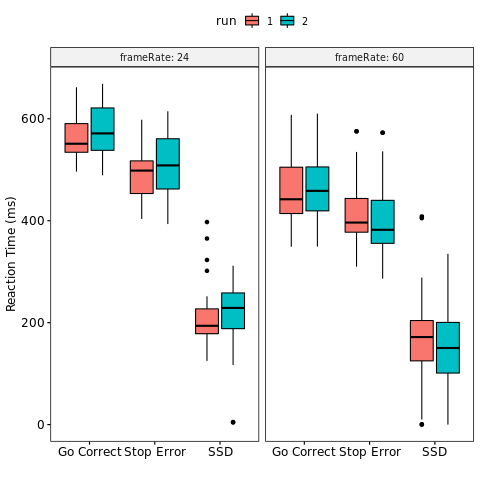

In [6]:
%%R
SST_long <- read.csv("/corral-secure/utdmc/Dell-Medical-Imaging/ULG/BIDS/derivatives/repo/fMRI-tasks/SST/data/SST_merged_bdat.csv")
SST_long$frameRate <- as.character(SST_long$frameRate)
SST_long$run <- as.factor(SST_long$run)

# manually change 038's framerate
SST_long$frameRate[SST_long$participant == 38 & SST_long$run == 1] <- 24

SST_long <- SST_long %>% mutate(frameRate = case_when(
        frameRate < 26 ~  24,
        frameRate > 58 ~ 60))

SST_long$frameRate <- as.factor(SST_long$frameRate)

# calculate corr go RT
SST_corr_go_rt <- SST_long %>%
  filter(trial_type == "go" & key_response.corr == 1) %>%
  group_by(participant, run) %>%
  summarise(go_correct_rt = 1000*mean(key_response.rt)) %>% ungroup()

# calc stop err RT
SST_stop_err_rt <- SST_long %>%
  filter(trial_type == "stop" & key_response.corr == 0) %>%
  group_by(participant, run) %>%
  summarise(stop_error_rt = 1000*mean(key_response.rt)) %>% ungroup() 

SST_wide <- SST_long %>% 
  filter(trial_type != "") %>%
  group_by(participant, trial_type, run, frameRate) %>%
  summarise(meanacc = mean(key_response.corr, na.rm = TRUE), meanrt = 1000* mean(key_response.rt, na.rm=TRUE), ssd = 1000*mean(ss_delay), stopError = sum(trial_type == "stop" & key_response.corr == 0), stopTotal = sum(trial_type == "stop"), GoCorr = sum(trial_type == "go" & key_response.corr == 1), GoTotal = sum(trial_type == "go")) %>% ungroup() 
            

SST_wide <- merge(SST_wide, SST_corr_go_rt, by = c('participant', 'run'))

SST_wide <- merge(SST_wide, SST_stop_err_rt, by = c('participant', 'run'))



SST_wide <- SST_wide %>% mutate(stopError_prop = stopError/stopTotal,
                    goCorr_prop = GoCorr/GoTotal)

SST_rt <- SST_wide %>% ungroup() %>% select(participant, run, frameRate, go_correct_rt, stop_error_rt, ssd) %>% gather(condition, value, go_correct_rt:ssd)

SST_prop <- merge(SST_wide %>% ungroup() %>% subset(trial_type == "go") %>% select(participant, run, frameRate, goCorr_prop), SST_wide %>% ungroup() %>% subset(trial_type == "stop") %>% select(participant, run, frameRate, stopError_prop), by = c("participant", "run", "frameRate"))

SST_prop <- gather(SST_prop, condition, value, goCorr_prop:stopError_prop)


SST_prop %>%
  group_by(condition, run) %>%
  ggboxplot(., "condition", "value", fill = "run", ylab = "Proportion of Responses", xlab = "", facet.by = "frameRate", short.panel.labs = FALSE) + 
    scale_x_discrete(labels = c('Go Correct','Stop Error', 'SSD')) 

SST_rt %>%
  group_by(condition, run) %>%
  ggboxplot(., "condition", "value", fill = "run", ylab = "Reaction Time (ms)", xlab = "", facet.by = "frameRate", short.panel.labs = FALSE) + 
    scale_x_discrete(labels = c('Go Correct','Stop Error', 'SSD'))


# calculate SSRT
- method 1: median corr_go_rt minus mean SSD
- method 2: Go RT at the percentile corresponding to the proportion of unsuccessfully inhibited stop trials and subtracting the mean stop-signal delay

/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: `stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

  warnings.warn(x, RRuntimeWarning)


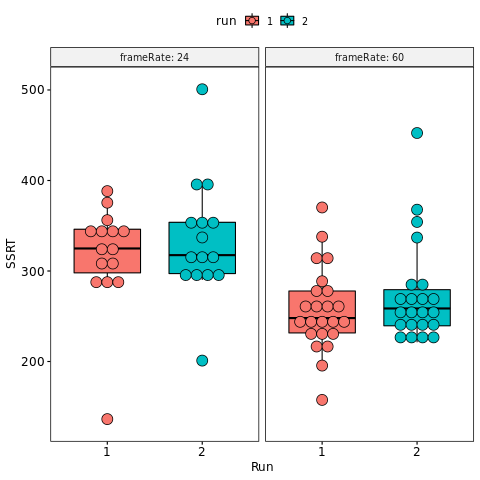

In [7]:
%%R
median_go_rt <- SST_long %>%
  filter(trial_type == 'go' & key_response.corr == 1) %>%
  group_by(participant, run, frameRate) %>%
  summarise(median = median(key_response.rt)) 

SST_long_stop_correct <- SST_long %>%
  filter(trial_type == 'stop' & key_response.corr == 1)

meanSSD <- SST_long_stop_correct %>% group_by(participant, run, frameRate) %>%
  summarise(meanSSD = mean(ss_delay)) 

SSRT <- merge(meanSSD, median_go_rt, by = c('participant','run', 'frameRate'))


mutate(SSRT, SSRT = 1000*(median - meanSSD)) %>%
  ggboxplot(., "run", "SSRT", fill = "run", ylab = "SSRT", xlab = "Run", facet.by = "frameRate", add = "dotplot", short.panel.labs = FALSE)

# coefficient of variation

/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: `stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

  warnings.warn(x, RRuntimeWarning)


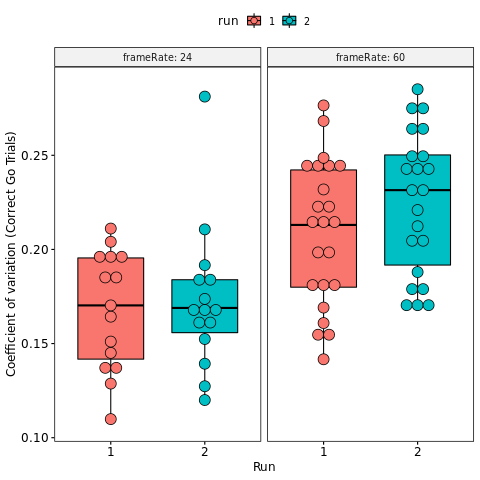

In [23]:
%%R

SST_long %>%
  filter(trial_type != "") %>%
  group_by(participant, run, trial_type, frameRate) %>%
  summarise(sd_rt = sd(key_response.rt, na.rm=TRUE), mean_rt = mean(key_response.rt, na.rm=TRUE)) %>%
  mutate(CoV = sd_rt/mean_rt) %>%
  filter(sd_rt > 0.001) %>%
  ggboxplot(., "trial_type", "CoV", fill = "run", ylab = "Coefficient of variation (all trials)", facet.by = "frameRate", xlab = "Trial Type", add = "dotplot", short.panel.labs = FALSE)

SST_long %>%
  filter(trial_type == 'go' & key_response.corr == 1) %>%
  group_by(participant, run, frameRate) %>%
  summarise(sd_rt = sd(key_response.rt), mean_rt = mean(key_response.rt)) %>%
  mutate(CoV = sd_rt/mean_rt) %>%
   filter(sd_rt > 0.001) %>% 
  ggboxplot(., "run", "CoV", fill = "run", ylab = "Coefficient of variation (Correct Go Trials)", xlab = "Run", facet.by = "frameRate", add = "dotplot", short.panel.labs = FALSE)